In [3]:
#%pip install hyperspectral_gta_data

In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [2]:
# To download and use the Washington DC image:
hsi_data.download('WashingtonDC')
fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# To download and use the polymers image:
# hsi_data.download('MicroscenePolymers')
# fname = 'Book Modules\spectral_images\Microscene_Polymers\reflectance_image_polymers

In [3]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')

# To work with the data, we usually reshape the data from an image (# rows, # cols, # bands)
# into a standard (# observations, # features) array as (# pixels, # bands)
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (1280, 307, 156)
Shape of imList = (392960, 156)


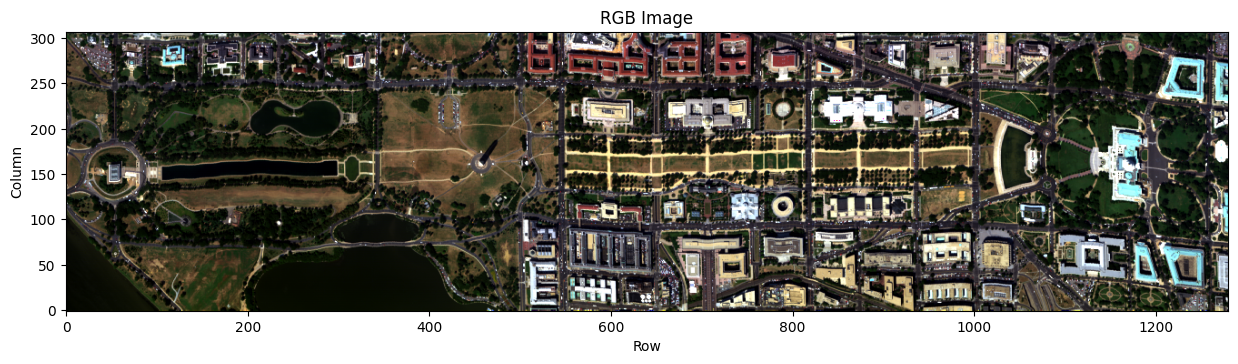

In [4]:
sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

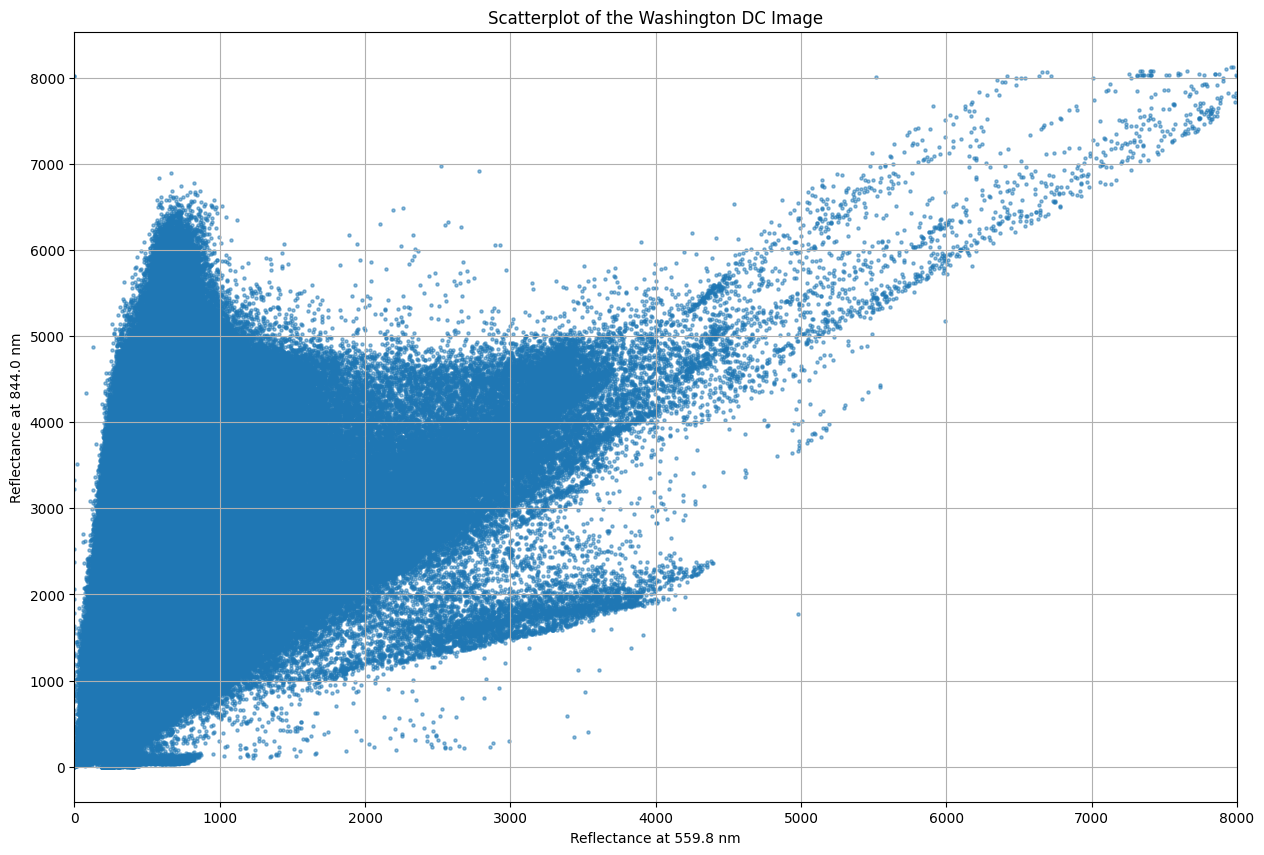

In [5]:
# Create a scatterplot of the data (pick 2 random bands to view)
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(imList[:,i1], imList[:,i2], s=5, alpha=0.5);
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Clustering using K-Means

Documentation on K Means clustering using sklearn in Python: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

A discussion of 11 clustering algorithms with Python implementations is provided in: https://scikit-learn.org/stable/modules/clustering.html

392960
[1 1 1 ... 2 0 2]


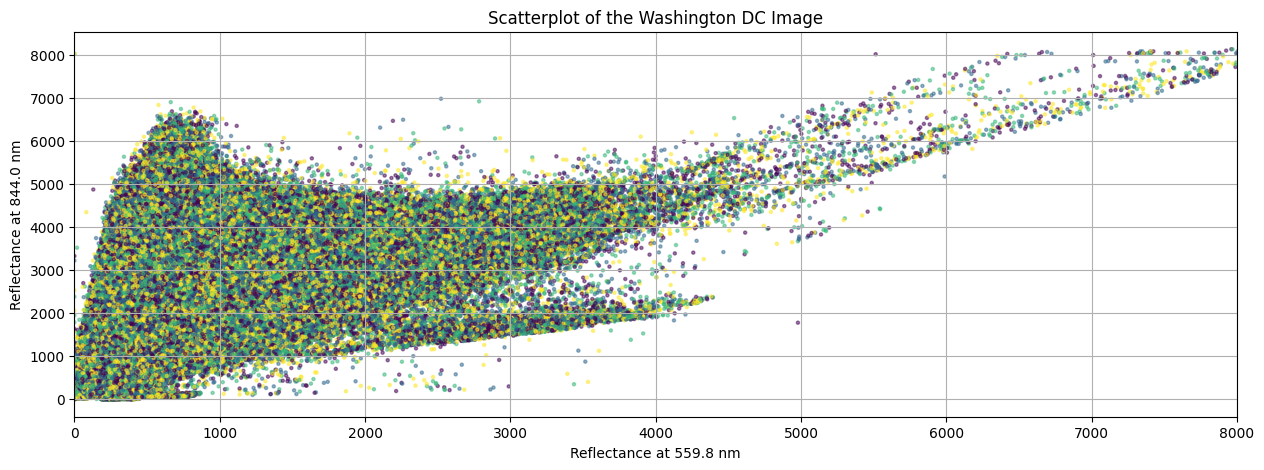

In [6]:
k = 4

# Step 0 - Assign random class value to each point
nRows, nCols, nBands = imArr.shape
nPix = nRows*nCols
print(nPix)
class_index = np.random.randint(low=0, high = k, size = nPix)
print(class_index)


# Create a scatterplot of the data with colors as class_index

plt.figure(figsize=(15,5))
plt.scatter(imList[:,i1], imList[:,i2], c = class_index, s=5, alpha=0.5);
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

In [28]:
# Create an array of normalized (subtract mean, divide by standard deviation) spectra
imListNormed = imListTemp = copy.copy(imList)
print(imListNormed.shape)
imList_mu = np.mean(imList, axis = 1) #take mean in a horizontal direction (take mean of each pixel over all bands)
print(imList_mu.shape)
for j in range(nBands):
    imListNormed[:,j] = imListNormed[:,j] - imList_mu #subtract the mean off every value
imList_stdev = np.sqrt((1/nBands)*np.sum(imListNormed**2, axis = 1))

print(imListNormed.shape)
print(imList_stdev.shape)

(392960, 156)
(392960,)
(392960, 156)
(392960,)


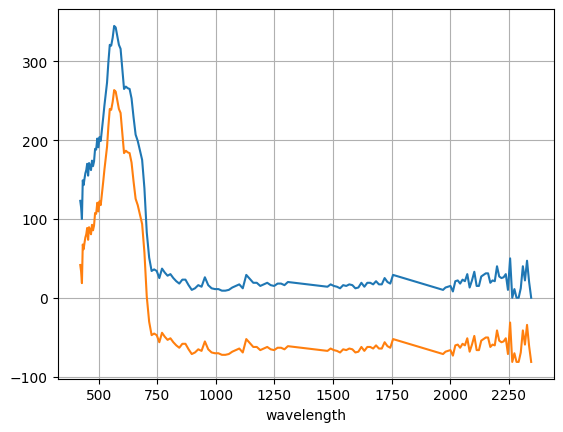

In [22]:
plt.figure()
plt.plot(wl,imList[1000,:])
plt.plot(wl,imListNormed[1000,:]) #pixel number 1000
plt.xlabel('wavelength')
plt.grid(True)

In [25]:
#Step 1 (Expectation): Compute the mean of each class (the expected value)

class_means = np.zeros((k,nBands))

for i in range(k):
    idx = np.where(class_index == i)
    class_means[i,:] = np.mean(np.squeeze(imList[idx,:]), axis = 0) #squeeze because imList[idx,:] returning with an extra value before columns and rows numbers

#Step 2 (Maximization): Re-assign each point to a class using the closest mean (the maximum likelihood)
distance_to_mean = np.zeros((nPix, k))
for ic in range(k): # i = index for each class
    imListTemp = copy.copy(imList) ##use copy or else anything done to imListTemp will happen to imList!!
    for j in range(nBands):
        imListTemp[:,j] = imListTemp[:,j] - class_means[ic,j] # euclidean distance (probably not the best for this problem - we want something that deals with angles)
    distance_to_mean[:,ic] = np.sum(imListTemp**2, axis=1) #compute error/distance to mean for each pixel (across each row) in each group
class_index = np.argmin(distance_to_mean, axis=1)




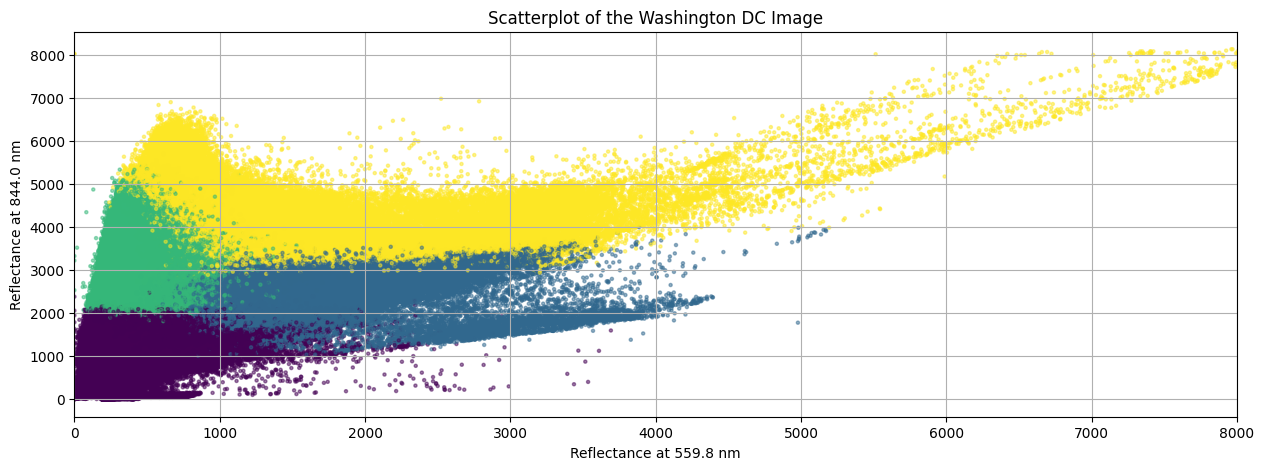

In [26]:
# Create a scatterplot of the data with updated class assignments

plt.figure(figsize=(15,5))
plt.scatter(imList[:,i1], imList[:,i2], c = class_index, s=5, alpha=0.5);#, label = f'Class {i}');
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');
#plt.legend()

#euclidean distance not great for spectral imageing - usually the skinny tail as shown below is its own cluster
#correlation gives a better way to compare spectra

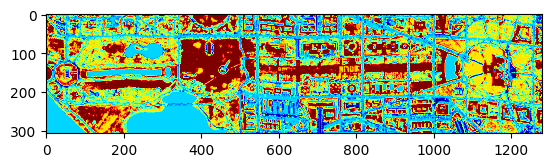

In [49]:
class_image = np.reshape(class_index, (nRows,nCols))
plt.imshow(np.rot90(class_image), cmap = 'jet')